# Goal
Once we have a trained a model, we want to see how well it performs in the test set.
We would also like to compare performance between the models, so this is what we are going to do in this notebook.

# 1. Imports

In [13]:
# Data tools
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import json
import sys
sys.path.append(".")
import gc

# Data visualization
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# Data loading and manipulation
from torch.utils.data import DataLoader
from packages.dataset import Dataset
import albumentations as albu
from packages.helpers import *

# Machine Learning model and training
import torch
import segmentation_models_pytorch as smp

# Clean cache
gc.collect()
torch.cuda.empty_cache()

# 2. Model and data
We are going to fetch a previsouly trained model in the "models" folder and use to infer predictions on the test dataset.

### 2.1. Global variables

In [14]:
DATA_DIR = 'data'
CLASSES = ['solar panel']
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'

PANELS, BACKGROUND = 0, 1

MASK_VALUE = BACKGROUND

### 2.1. Load model

In [15]:
best_model = torch.load('./best_model_unet_1_200.pth')

### 2.2. Setup test dataset

In [16]:
# Define path for testing data
x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

# Parameters
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

# Build dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
    mask_value=MASK_VALUE
)

# Load dataset
test_dataloader = DataLoader(test_dataset)

# 3. Evaluate model on test set

### 3.1. Loss and optimization functions

In [17]:
loss = smp.utils.losses.DiceLoss()
loss = smp.losses.SoftBCEWithLogitsLoss()
loss.__name__ = "SoftBCEWithLogitsLoss"

# loss_weights = [1, 100] # 1 for background and 10 for solar panel
# loss = smp.losses.CategoricalCELoss(class_weights=loss_weights)
# loss.__name__ = "CategoricalCELoss"

metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(),
    smp.utils.metrics.Accuracy(),
    smp.utils.metrics.Recall(),
    smp.utils.metrics.Precision(),
]

### 3.2. Run testing

In [18]:
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 71/71 [00:05<00:00, 12.76it/s, SoftBCEWithLogitsLoss - 0.3186, iou_score - 0.9966]


# 4. Extract metrics

In [19]:
logs

{'SoftBCEWithLogitsLoss': 0.31856506475260565, 'iou_score': 0.9965974008533316}

# 5. Visualize predictions

In [20]:
# Get test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
    mask_value=MASK_VALUE
)

In [21]:
def custom_metrics(truth, pre):

    gt = torch.from_numpy(truth)
    pred = torch.from_numpy(pre)


    tp = torch.sum((pred == 1) * (gt == 1))          # true positives: all pixels where both prediction and ground truth is one (solar panel)
    fp = torch.sum((pred == 1) * (gt == 0))          # false positives: prediction = one, ground truth = 0 (background)
    fn = torch.sum((pred == 0) * (gt == 1))          # false negatives: inverse

    precision = tp/(tp + fp)
    recall = tp/(tp + fn) 
    
    return precision, recall


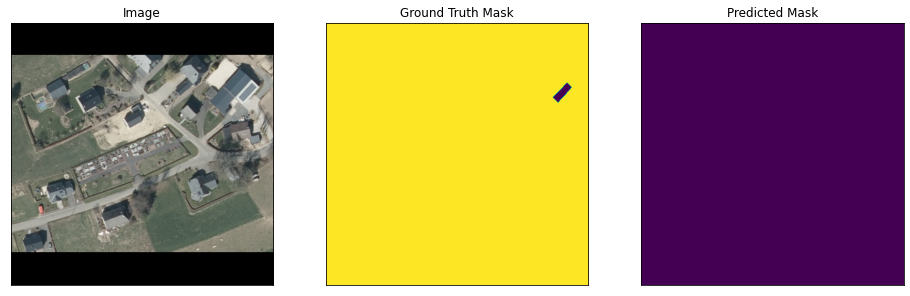

precision: 0.9979383945465088, recall: 1.0


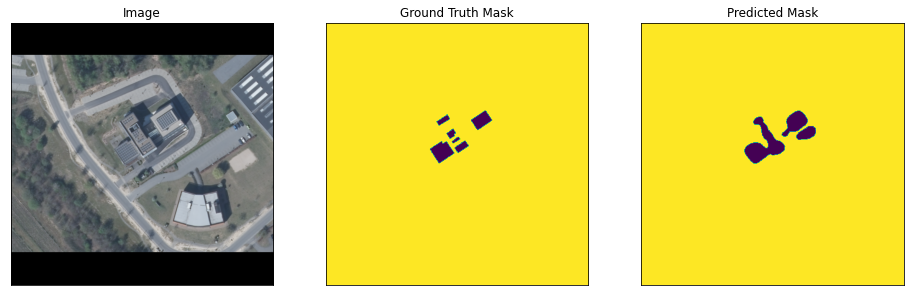

precision: 0.999531090259552, recall: 0.991083025932312


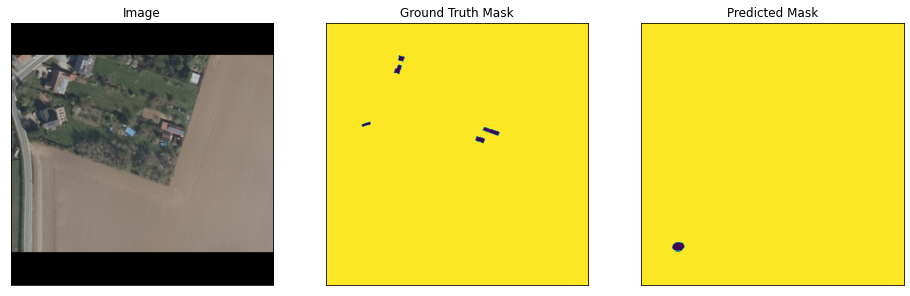

precision: 0.9972449541091919, recall: 0.9987987875938416


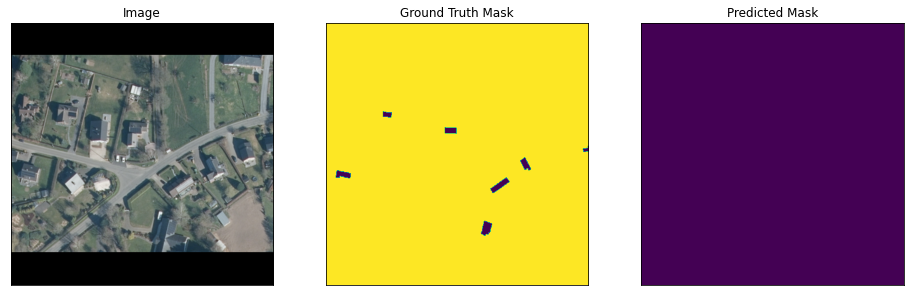

precision: 0.9930295348167419, recall: 1.0


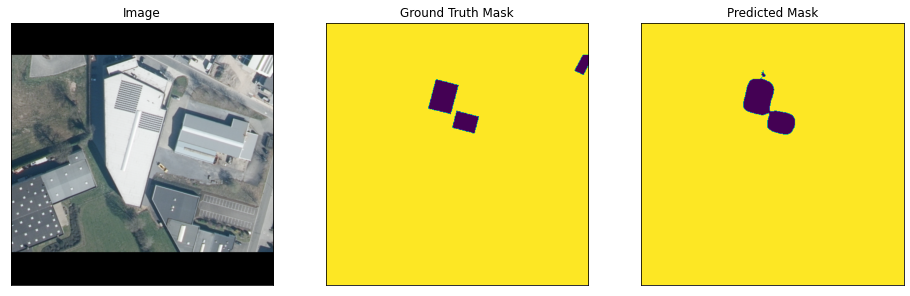

precision: 0.9973772168159485, recall: 0.9953619241714478


In [22]:
# 0 is a solar panel prediction and 1 is background prediction
threshold = 0.8

for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    # print(pr_mask)
    # print()
    #pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    pr_mask = (pr_mask.squeeze().cpu().numpy())
    pr_mask[pr_mask <= threshold] = 0
    pr_mask[pr_mask > threshold] = 1
    # print(pr_mask)
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

    precision, recall = custom_metrics(gt_mask, pr_mask)

    print(f'precision: {precision}, recall: {recall}')
